<a href="https://colab.research.google.com/github/jfodera/proj-ai-ml/blob/main/proj-ai-ml/Lab01/01_datasheet_and_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 Week 1: Datasheet and Audit

Notebook: 01_datasheet_and_audit.ipynb

Student Name: Joseph Fodera

Date: February 5, 2026

Dataset: Surgical-deepnet.csv from Kaggle (https://www.kaggle.com/datasets/omnamahshivai/surgical-dataset-binary-classification)

Task: Binary Classification - Predict 'complication' (0/1) from patient features.

This notebook covers Part A (Datasheet + Quality Audit + Leakage Note) and Part B (Leakage-safe Split + Pipeline + Baseline).

## Imports and Setup

Import required libraries and set random seed for reproducibility.

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Part A: Dataset Datasheet

### Motivation

This dataset exists to support predictive modeling of postoperative complications in surgical patients, enabling the development and evaluation of machine learning models that can identify individuals at higher risk based on preoperative features. The primary purpose is educational and exploratory: to demonstrate real-world supervised learning challenges in healthcare, such as handling imbalanced outcomes, preventing data leakage from risk-derived features, and building reproducible pipelines for binary risk prediction. Accurate early identification of complication risk could ultimately inform clinical decision-making, resource allocation, and patient counseling to improve outcomes and reduce avoidable harm after surgery.

### Target Definition
- Target: 'complication' (binary: 0 = no complication, 1 = complication)
- Positive class represents: Presence of surgical complication (event/risk with asymmetric FP/FN costs, e.g., FN misses a complication leading to harm).

### Data Source and License
- Source: Kaggle dataset uploaded by user 'omnamahshivai'; origin likely anonymized medical records (exact source unknown).
- Download Link: https://www.kaggle.com/datasets/omnamahshivai/surgical-dataset-binary-classification/download
- License/Terms: Unknown (Kaggle default: use for non-commercial purposes; assume fair use for educational ML).

### Brief Feature Dictionary
Dataset has 14,635 rows and 25 features (all numeric after loading).

Top features (with types and brief descriptions):
- bmi (float64): Body Mass Index
- Age (float64): Patient age in years
- asa_status (int64): ASA physical status classification (0-2?)
- baseline_cancer (int64): Binary indicator for baseline cancer
- baseline_charlson (int64): Charlson Comorbidity Index
- baseline_cvd (int64): Binary for cardiovascular disease
- baseline_dementia (int64): Binary for dementia
- baseline_diabetes (int64): Binary for diabetes
- baseline_digestive (int64): Binary for digestive issues
- baseline_osteoart (int64): Binary for osteoarthritis
- baseline_psych (int64): Binary for psychiatric conditions
- baseline_pulmonary (int64): Binary for pulmonary issues
- ahrq_ccs (int64): AHRQ Clinical Classification System code
- ccsComplicationRate (float64): Complication rate from CCS
- ccsMort30Rate (float64): 30-day mortality rate from CCS
- complication_rsi (float64): Risk score index for complication
- dow (int64): Day of week (0-4)
- gender (int64): Binary (0/1)
- hour (float64): Time of day (hour)
- month (int64): Month (0-11?)
- moonphase (int64): Moon phase (0-3?)
- mort30 (int64): Binary 30-day mortality
- mortality_rsi (float64): Risk score index for mortality
- race (int64): Categorical (0-2)
- complication (int64): Target

### Known Limitations/Risks
- Imbalanced target (75% no complication, 25% yes).
- Potential biases: Race/gender distributions may not represent diverse populations.
- Anonymized data: No sensitive info, but ethics in medical predictions (e.g., avoid harm from false negatives).
- Size: 14k rows, but 2.9k duplicates.


## Part A: Data-Quality Audit

In [23]:
df = pd.read_csv('Surgical-deepnet.csv')
print(df.shape)
print(df.columns.tolist())
print(df.dtypes)

(14635, 25)
['bmi', 'Age', 'asa_status', 'baseline_cancer', 'baseline_charlson', 'baseline_cvd', 'baseline_dementia', 'baseline_diabetes', 'baseline_digestive', 'baseline_osteoart', 'baseline_psych', 'baseline_pulmonary', 'ahrq_ccs', 'ccsComplicationRate', 'ccsMort30Rate', 'complication_rsi', 'dow', 'gender', 'hour', 'month', 'moonphase', 'mort30', 'mortality_rsi', 'race', 'complication']
bmi                    float64
Age                    float64
asa_status               int64
baseline_cancer          int64
baseline_charlson        int64
baseline_cvd             int64
baseline_dementia        int64
baseline_diabetes        int64
baseline_digestive       int64
baseline_osteoart        int64
baseline_psych           int64
baseline_pulmonary       int64
ahrq_ccs                 int64
ccsComplicationRate    float64
ccsMort30Rate          float64
complication_rsi       float64
dow                      int64
gender                   int64
hour                   float64
month              

### Missingness Summary

In [24]:
print(df.isna().sum())
print('Missing percentages:')
print(df.isna().mean() * 100)

bmi                    0
Age                    0
asa_status             0
baseline_cancer        0
baseline_charlson      0
baseline_cvd           0
baseline_dementia      0
baseline_diabetes      0
baseline_digestive     0
baseline_osteoart      0
baseline_psych         0
baseline_pulmonary     0
ahrq_ccs               0
ccsComplicationRate    0
ccsMort30Rate          0
complication_rsi       0
dow                    0
gender                 0
hour                   0
month                  0
moonphase              0
mort30                 0
mortality_rsi          0
race                   0
complication           0
dtype: int64
Missing percentages:
bmi                    0.0
Age                    0.0
asa_status             0.0
baseline_cancer        0.0
baseline_charlson      0.0
baseline_cvd           0.0
baseline_dementia      0.0
baseline_diabetes      0.0
baseline_digestive     0.0
baseline_osteoart      0.0
baseline_psych         0.0
baseline_pulmonary     0.0
ahrq_ccs         

### Duplicate Rows Check

In [25]:
print(df.duplicated().sum())

2902


### Target Distribution

complication
0    0.747865
1    0.252135
Name: proportion, dtype: float64


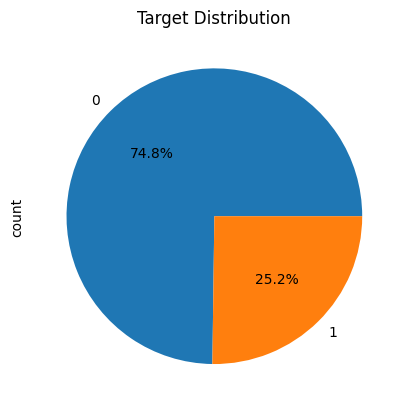

In [26]:
print(df['complication'].value_counts(normalize=True))
df['complication'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

### One Bias/Ethics Consideration

The 'race' feature is highly imbalanced, with approximately 86% of samples belonging to race=1 (likely the majority group), 11% to race=0, and 3% to race=2. This skewness could lead to a model that performs poorly on underrepresented racial groups, potentially perpetuating biases in healthcare predictions. Ethical risk: Deployed models might disadvantage minority patients by underpredicting complications, leading to unequal care. Mitigation: Monitor for disparate impact across groups in future evaluations and consider oversampling or fairness-aware modeling if needed.

In [27]:
print(df['race'].value_counts(normalize=True))

race
1    0.86054
0    0.11001
2    0.02945
Name: proportion, dtype: float64


## Part A: Leakage-Risk Note

Plausible leakage vectors:
1. Post-outcome fields: 'ccsComplicationRate', 'complication_rsi' (seem derived from complications), 'ccsMort30Rate', 'mortality_rsi', 'mort30' (related outcomes).
2. Time-related: 'dow', 'hour', 'month', 'moonphase' - if data is chronological, future data could leak.
3. Duplicates/near-duplicates: 2902 duplicates - remove to avoid memorization.
4. No explicit IDs, but possible implicit (e.g., similar rows).

Prevention:
- Drop leakage columns before split: ['ccsComplicationRate', 'ccsMort30Rate', 'complication_rsi', 'mortality_rsi', 'mort30']
- If temporal (sort by month/hour?), use time-based split (train on early, test on late).
- Remove duplicates.
- Justify: No time ordering evident (data not sorted, month/hour not sequential), so use stratified random split.

## Part B: Leakage-Safe Preprocessing and Baselines

### Data Cleaning (Pre-Split)

In [28]:
leakage_cols = ['ccsComplicationRate', 'ccsMort30Rate', 'complication_rsi', 'mortality_rsi', 'mort30']

# Drop duplicates
df = df.drop_duplicates()

# Drop leakage columns
df = df.drop(columns=leakage_cols)

# Define X/y
X = df.drop('complication', axis=1)
y = df['complication']

### Leakage-Safe Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### Build scikit-learn Pipeline

In [30]:
# All features numeric, no ColumnTransformer needed
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GaussianNB())
])

### Train Simple Baseline Model

Choose one: GaussianNB(), KNeighborsClassifier(), etc.

In [31]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### Report Primary Metric and Artifact

Primary: F1-score (since imbalanced).
Artifact: Confusion matrix.

F1 Score: 0.3666061705989111
Confusion Matrix:
[[1447  162]
 [ 536  202]]


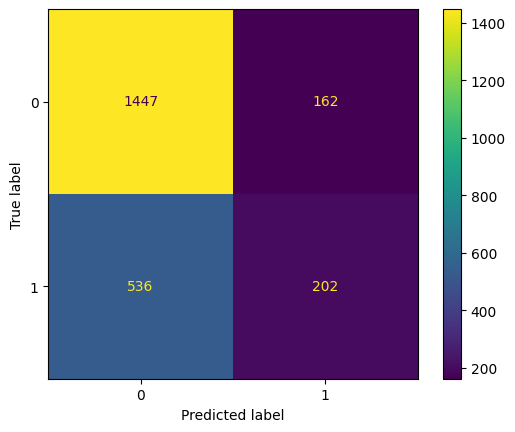

In [32]:
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()